## Capstone Project: Seoul Bike Sharing Demand

The main purpose of this project is to analyze weather data, date information, and the count of rented bikes per hour obtained from the bike sharing systems in Seoul to uncover the behaviors of rental bike users and predict rental bike demand. In this project, clustering techniques (K-prototypes algorithm) are employed to group data based on their similarity or closeness to each other to explore the patterns of rental behavior. Besides, four regression models, including Gradient Boosting Machine (GBM), CUBIST Model, Multi Layer Perceptron (MLP), and Ridge Regression are developed to predict the rental bike demand. The dataset is distributed into a 75% training set and a 25% test set, with 10-fold cross-validation equipped with the training set to avoid overfitting. R-squared (R²), Mean Squared Error (MSE), and Mean Absolute Error (MAE) are used for evaluating the models.

In [1]:
!pip install cubist
!pip install kmodes
!pip install ucimlrepo
!pip install ipdb
!pip install scikeras
!pip install --upgrade kneed
!pip3 install tabulate
from ucimlrepo import fetch_ucirepo
from sklearn import datasets
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from cubist import Cubist
import time
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from keras.models import Sequential
from kmodes.kprototypes import KPrototypes
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error
from scikeras.wrappers import KerasRegressor
from scipy import stats
from kneed import KneeLocator
from sklearn import preprocessing
from tabulate import tabulate
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import ipdb;ipdb
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 582.0/582.0 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 29.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.1 which is incompatible


## Data Preparation

In [3]:
# Import the datset
seoul_bike_sharing_demand = fetch_ucirepo(id=560)
X = seoul_bike_sharing_demand.data.features
y = seoul_bike_sharing_demand.data.targets
bike_df = pd.concat([X, y], axis=1)

# Display the first 5 rows of the dataset
print(bike_df.head(5))

        Date  Rented Bike Count  Hour  Temperature  Humidity  Wind speed  \
0  1/12/2017                254     0         -5.2        37         2.2   
1  1/12/2017                204     1         -5.5        38         0.8   
2  1/12/2017                173     2         -6.0        39         1.0   
3  1/12/2017                107     3         -6.2        40         0.9   
4  1/12/2017                 78     4         -6.0        36         2.3   

   Visibility  Dew point temperature  Solar Radiation  Rainfall  Snowfall  \
0        2000                  -17.6              0.0       0.0       0.0   
1        2000                  -17.6              0.0       0.0       0.0   
2        2000                  -17.7              0.0       0.0       0.0   
3        2000                  -17.6              0.0       0.0       0.0   
4        2000                  -18.6              0.0       0.0       0.0   

  Seasons     Holiday Functioning Day  
0  Winter  No Holiday             Yes  


In [ ]:
# Check the data types of the variables
bike_df.dtypes

Date                      object
Rented Bike Count          int64
Hour                       int64
Temperature              float64
Humidity                   int64
Wind speed               float64
Visibility                 int64
Dew point temperature    float64
Solar Radiation          float64
Rainfall                 float64
Snowfall                 float64
Seasons                   object
Holiday                   object
Functioning Day           object
dtype: object

In [ ]:
# Check if there are missing values in the datset
bike_df.isnull().sum()

Date                     0
Rented Bike Count        0
Hour                     0
Temperature              0
Humidity                 0
Wind speed               0
Visibility               0
Dew point temperature    0
Solar Radiation          0
Rainfall                 0
Snowfall                 0
Seasons                  0
Holiday                  0
Functioning Day          0
dtype: int64

In [ ]:
# Check if there are duplicated data
bike_df.duplicated().sum()

0

It is confirmed the dataset is clean and organized, with no missing values and missing values, and correct data type.

## Exploratory data analysis (EDA)

In [ ]:
#Show the basic statistics description
bike_df_description = bike_df.describe(include='all')
print(bike_df_description)

             Date  Rented Bike Count         Hour  Temperature     Humidity  \
count        8760        8760.000000  8760.000000  8760.000000  8760.000000   
unique        365                NaN          NaN          NaN          NaN   
top     1/12/2017                NaN          NaN          NaN          NaN   
freq           24                NaN          NaN          NaN          NaN   
mean          NaN         704.602055    11.500000    12.882922    58.226256   
std           NaN         644.997468     6.922582    11.944825    20.362413   
min           NaN           0.000000     0.000000   -17.800000     0.000000   
25%           NaN         191.000000     5.750000     3.500000    42.000000   
50%           NaN         504.500000    11.500000    13.700000    57.000000   
75%           NaN        1065.250000    17.250000    22.500000    74.000000   
max           NaN        3556.000000    23.000000    39.400000    98.000000   

         Wind speed   Visibility  Dew point tempera

The code above generates the basic statistics, such as mean, median, and standard deviation (SD), of all features of the bike dataset. There has 365 unique dates, with each date occurring 24 times since there are 24 hours in a day (8760 instances in total). The Rented Bike Count (target varibale) has a mean of 704.6 rentals per hour, a median of 504.5 rentals, and the significantly large standard deviation of 644.99 showing us how drastically the counts fluctuate; their range goes from as low as 0 rentals to as high as 3556 rentals.

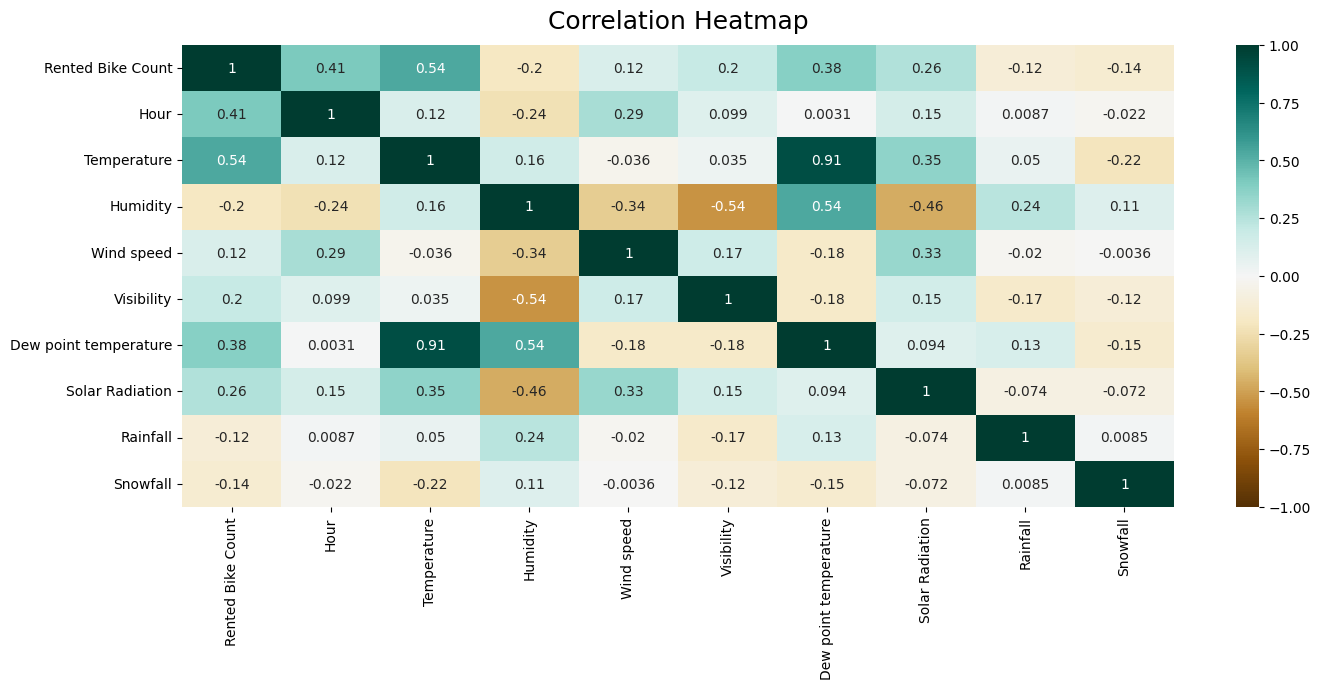

In [ ]:
# Filter only numeric columns
numeric_bike_df = bike_df.select_dtypes(include=[np.number])

# Create a heatmap to show the correleations between numerical variables
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(numeric_bike_df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

plt.show()

Based on the heatmap above, the rental bike demand positively correlates with temperature, hour, wind speed, visibility, dew point temperature, and solar radiation, among which temperature (0.54) shows the strongest positive correlation, followed by hour (0.41). It indicates the noticeable impact of temperature and hour on customer behaviors with regard to bicycle rentals, with a higher demand in warmer weather in general. On the other hand, it negatively correlates with humidity, snowfall and rainfall, with coefficients of -0.2 for humidity, -0.14 for snowfall, and -0.12 for rainfall.The heatmap also indicates a significantly high correlation (0.91) between dew point temperature and temperature. Since temperature has a relatively stronger correlation with the rented bike count, dew point temperature will be dropped for regression and clustering analysis to simplify the computation.

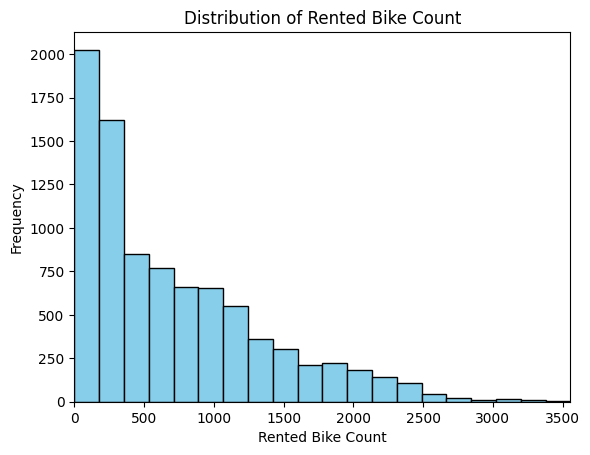

In [ ]:
# Create a histogram for the 'Rented Bike Count' column
plt.hist(bike_df['Rented Bike Count'], bins=20, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Rented Bike Count')
plt.ylabel('Frequency')
plt.title('Distribution of Rented Bike Count')

# Adjust x-axis range
plt.xlim(0, bike_df['Rented Bike Count'].max())

# Show the plot
plt.show()


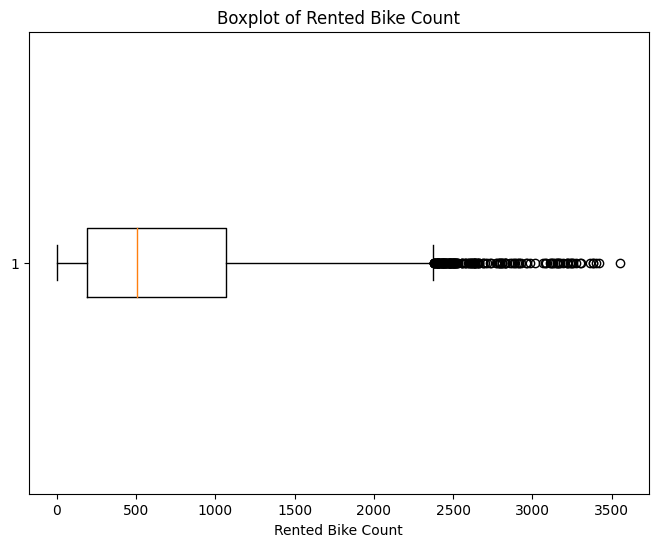

Upper Bound for Outliers: 2376.625


In [ ]:
# Create a boxplot for the 'Rented Bike Count' to find out the outliers
plt.figure(figsize=(8, 6))
plt.boxplot(bike_df['Rented Bike Count'], vert=False)
# Add labels and title
plt.xlabel('Rented Bike Count')
plt.title('Boxplot of Rented Bike Count')
# Show the plot
plt.show()

# Calculate the upper bound/ outer upper fence of rented bike count

# Calculate the lower quartile
Q1 = np.percentile(bike_df['Rented Bike Count'], 25)
# Calculate the upper quartile
Q3 = np.percentile(bike_df['Rented Bike Count'], 75)

IQR = Q3 - Q1

# Calculate the upper bound
upper_bound = Q3 + 1.5 * IQR

print("Upper Bound for Outliers:", upper_bound)



The the graphs above shows the distribution of rented bike count. From the first gragh, it can be observed that rented bike count follows a right-skewed distribution, with higher frequency in lower rented bike instances. Since it is not normally distribution, Tukey’s (boxplot) method is used to identify the outliers. In the boxplot, it indicates that the median of rented bike count is 504.50, with an IQR of 874.25 (Upper quartile = 1065.25, Lower quartile = 191), and the upper bound being 2376.62 per hour. Any rented bike counts per hour exceeding this upper bound are considered outliers.

<ipython-input-9-b06958e47036>:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[0].scatter(bike_df['Temperature'], bike_df["Rented Bike Count"], c=colors, cmap='coolwarm')
<ipython-input-9-b06958e47036>:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[1].scatter(bike_df['Hour'], bike_df["Rented Bike Count"], c=colors, cmap='coolwarm')


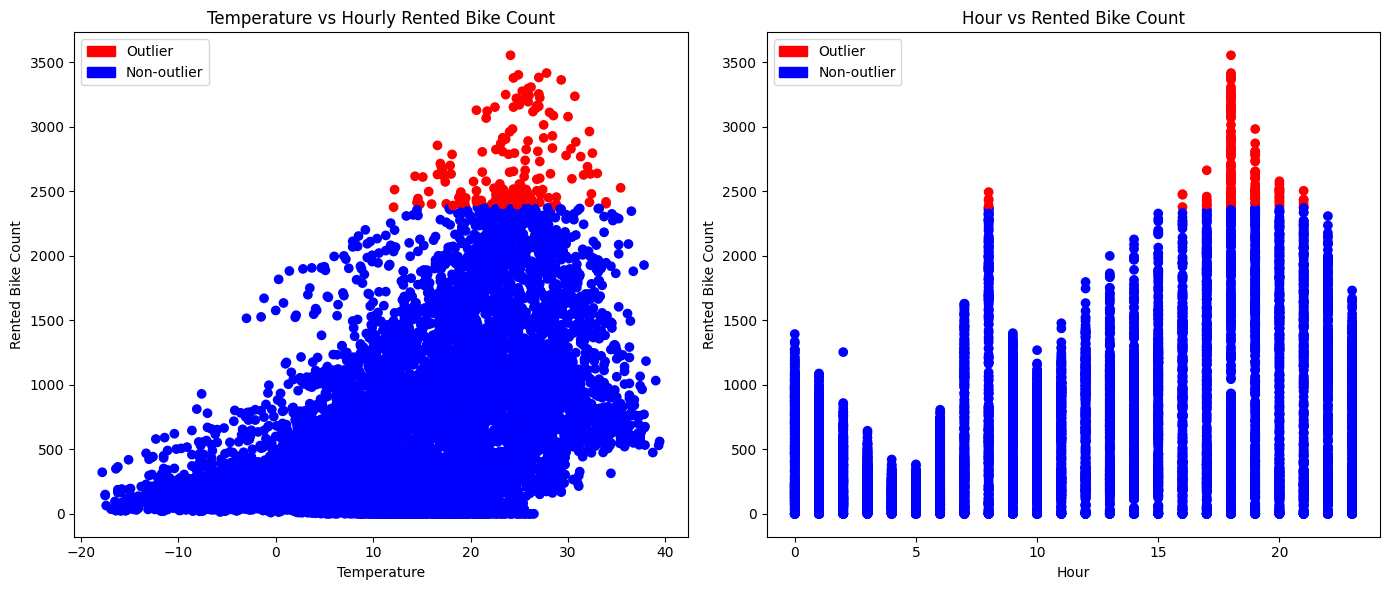

In [ ]:
# The instances are outliers if rented bike counts are more than 2376.625
condition = bike_df["Rented Bike Count"] > 2376.625
# Red represents outliers and blue represents non-outliers
colors = np.where(condition, 'red', 'blue')

# Create a figure with two plots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot the scatter plot for Temperature vs Rented Bike Count with different colors based on the condition.
axs[0].scatter(bike_df['Temperature'], bike_df["Rented Bike Count"], c=colors, cmap='coolwarm')
axs[0].set_xlabel('Temperature')
axs[0].set_ylabel('Rented Bike Count')
axs[0].set_title('Temperature vs Hourly Rented Bike Count')

# Create a custom legend
red_patch = mpatches.Patch(color='red', label='Outlier')
blue_patch = mpatches.Patch(color='blue', label='Non-outlier')
axs[0].legend(handles=[red_patch, blue_patch], loc='upper left')

# Plot the scatter plot for Hour vs Rented Bike with different colors based on the condition.
axs[1].scatter(bike_df['Hour'], bike_df["Rented Bike Count"], c=colors, cmap='coolwarm')
axs[1].set_xlabel('Hour')
axs[1].set_ylabel('Rented Bike Count')
axs[1].set_title('Hour vs Rented Bike Count')

# Create a custom legend
axs[1].legend(handles=[red_patch, blue_patch], loc='upper left')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

The two plots above indicate that the outliers (i.e., hours with more than 2376.62 rented bikes) mainly occur in the evening, with a few days experiencing busy mornings and outliers at 8 am, and with the temperature between 10°C to 30°C. Users' behaviors can also be observed from these plots. The temperature plot shows that warmer temperatures lead to higher demand for rental bikes, but once the temperature exceeds 30°C, the demand starts decreasing. The plot for hours indicates that the peaks in demand occur in the mornings and evenings at 8 AM and 6 PM, respectively. This could be explained by people using the rental bike service for commuting to work and returning home.

Outliers in the dataset occur naturally, reflecting Real-World variability and capturing unusual but valid patterns of rental bike users’ behaviors , therefore, it is crucial for machine learning models to perform with the presence of the outliers. Hence, outliers are retained for clustering and regression analysis.

The graphs regarding the rental bike demand by seasons and holidays/non-holidays are shown below.

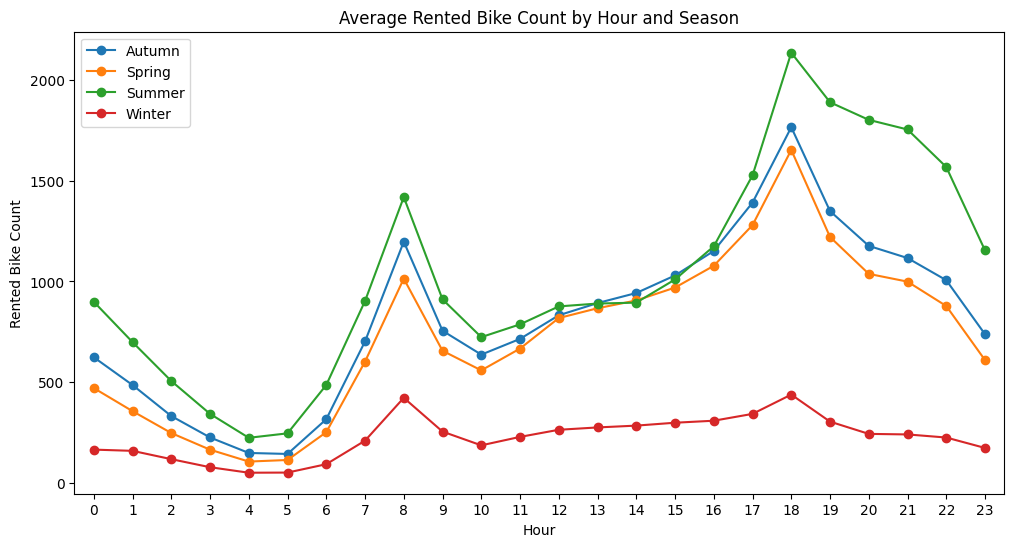

In [ ]:
plt.figure(figsize=(12, 6))

# Group the data by 'Hour', 'Seasons', and calculate the mean 'Rented Bike Count' for each hour and season
hourly_season_counts = bike_df.groupby(['Hour', 'Seasons'])['Rented Bike Count'].mean().unstack()

# Plot a line plot for each season
for season in hourly_season_counts.columns:
    plt.plot(hourly_season_counts.index, hourly_season_counts[season], marker='o', label=season)

plt.xlabel('Hour')
plt.ylabel('Rented Bike Count')
plt.title('Average Rented Bike Count by Hour and Season')
plt.legend()
plt.xlim(-0.5, 23.5)
# make x-axis ticks to show all 24 hours
plt.xticks(range(24))

plt.show()


The graph above shows that rental bike usage is significantly lower in winter compared to other seasons when the temperature is not too cold. Out of all four seasons, summer has the most usage for almost all hours of the day. Regardless of the season, rental bike usage also peaks at 8 AM in the morning and 6 PM in the evening

<ipython-input-11-5a7730f1ae0b>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=bike_df, x='Rented Bike Count', y='Holiday', inner='box', palette='Dark2',


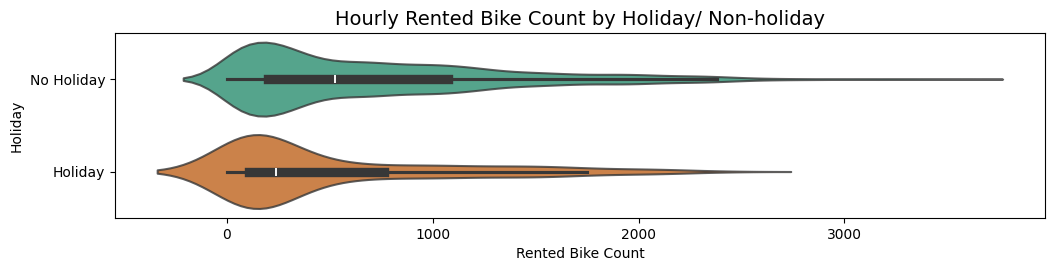

In [ ]:
figsize_season_count = (12, 1.2 * len(bike_df['Holiday'].unique()))

# Create a figure and axis
fig, ax = plt.subplots(figsize=figsize_season_count)

# Plot violin plot with boxplot inside
sns.violinplot(data=bike_df, x='Rented Bike Count', y='Holiday', inner='box', palette='Dark2',
               linewidth=1.5, width=0.8, alpha=0.8, ax=ax)

# Set title
ax.set_title('Hourly Rented Bike Count by Holiday/ Non-holiday', fontsize=14)

# Show the plot
plt.show()

Based on the plot above, people in Seoul tend to rent more bikes on regular days compared to holidays

## Feature Engineering

To enhance the dataset for analysis, extensive feature engineering was performed. Compared to the raw date, temporal components derived from the date, such as months and days of the week, can reveal temporal patterns that are more stable and consistent over time, and improve the prediction accuracy of models. Therefore, The original date feature was separated into 5 meaningful temporal features below


*   Day (int64): A specific day of a month that
*   Month (object): A specific month that the data was collected
*   Year (int64): A year that the data was collected
*   Day of the week (object): Day of the week (e.g., Monday, Tuesday)
*   Week status (object): Whether the day was in weekday/ weekend

In [4]:
# Make a copy of bike_df for feature engineering
bike_df_fe = bike_df.copy()

# Convert 'Date' column into datetime format
bike_df_fe['Date'] = pd.to_datetime(bike_df_fe['Date'], format='%d/%m/%Y')

# Separate Day, Month (abbreviation), and Year from 'Date'
bike_df_fe['Day'] = bike_df_fe['Date'].dt.day
bike_df_fe['Year'] = bike_df_fe['Date'].dt.year
bike_df_fe['Month'] = bike_df_fe['Date'].dt.strftime('%b')

# Extract Day of the Week (0 = Monday, 6 = Sunday) from date
bike_df_fe['Day of the week'] = bike_df_fe['Date'].dt.dayofweek
# Create new columns for week status (weekday/weekend) and day of the week (Monday to Sunday) categories
bike_df_fe['Week status'] = bike_df_fe['Day of the week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')
bike_df_fe['Day of the week'] = bike_df_fe['Date'].dt.day_name()

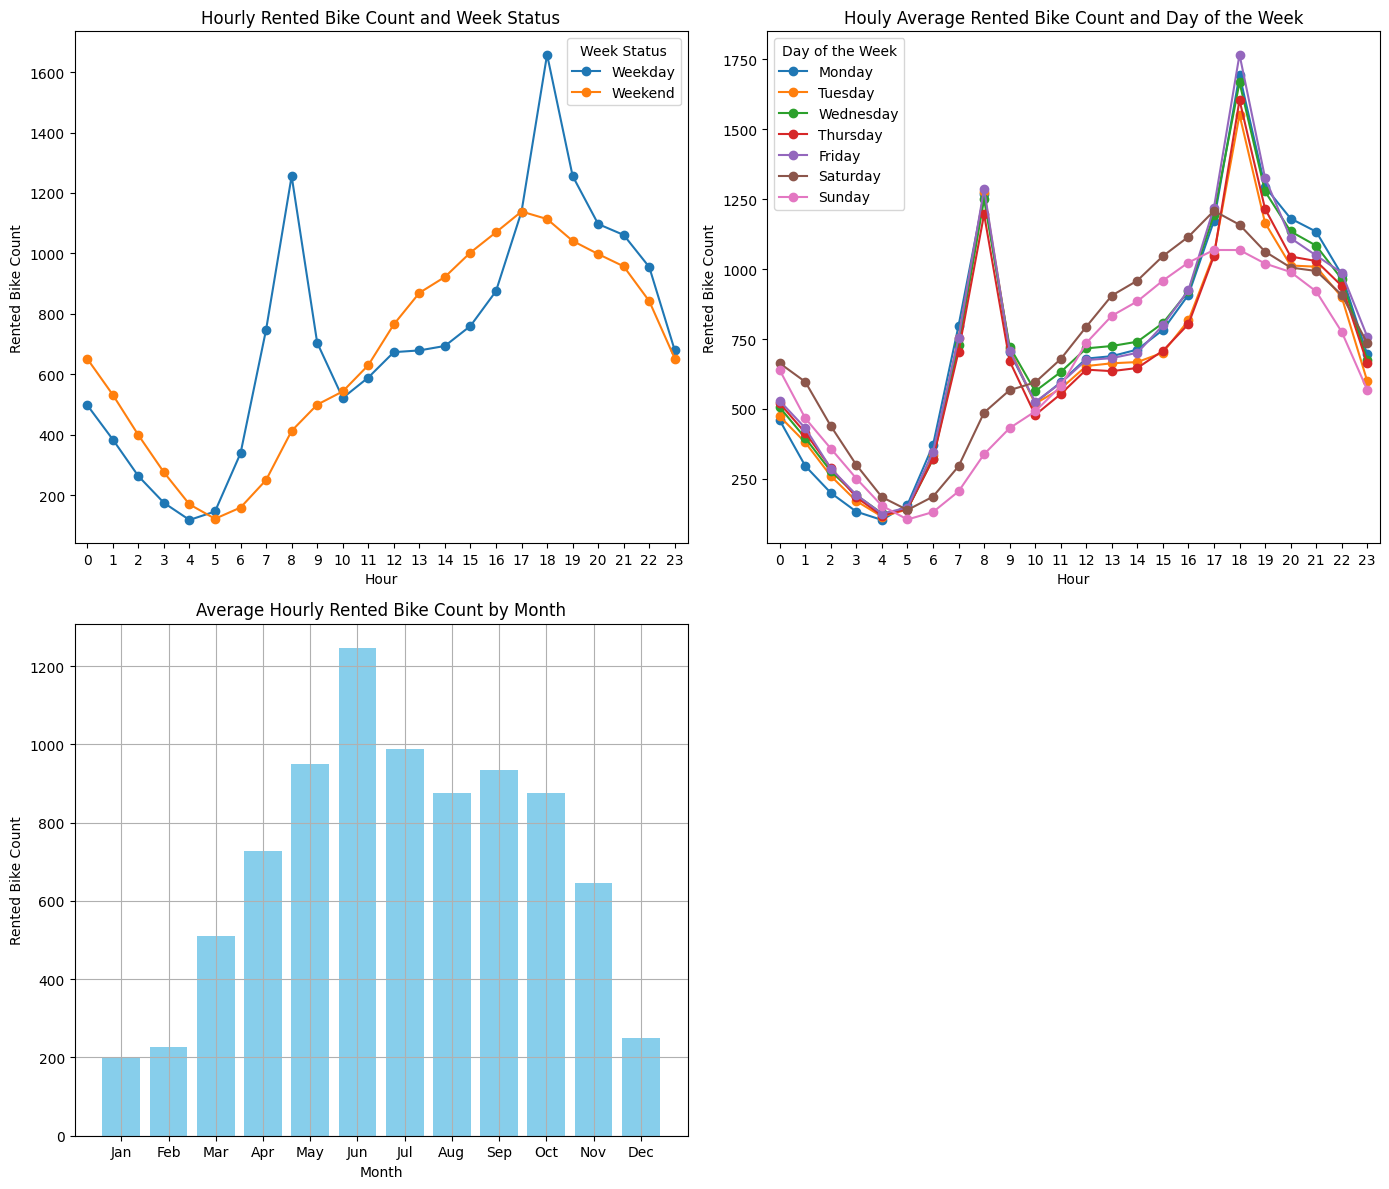

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

# Plot a line plot for Houly Average Rented Bike Count and Week Status
hourly_week_counts = bike_df_fe.groupby(['Hour', 'Week status'])['Rented Bike Count'].mean().unstack()
for status in hourly_week_counts.columns:
    axs[0, 0].plot(hourly_week_counts.index, hourly_week_counts[status], marker='o', label=status)
axs[0, 0].set_xlabel('Hour')
axs[0, 0].set_ylabel('Rented Bike Count')
axs[0, 0].set_title('Hourly Rented Bike Count and Week Status')
axs[0, 0].legend(title='Week Status')
axs[0, 0].set_xlim(-0.5, 23.5)
axs[0, 0].set_xticks(range(24))

# Plot a line plot for Houly Average Rented Bike Count and Day of the Week
hourly_day_counts = bike_df_fe.groupby(['Hour', 'Day of the week'])['Rented Bike Count'].mean().unstack()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for day in day_order:
    if day in hourly_day_counts.columns:
        axs[0, 1].plot(hourly_day_counts.index, hourly_day_counts[day], marker='o', label=day)
axs[0, 1].set_xlabel('Hour')
axs[0, 1].set_ylabel('Rented Bike Count')
axs[0, 1].set_title('Houly Average Rented Bike Count and Day of the Week')
axs[0, 1].legend(title='Day of the Week')
axs[0, 1].set_xlim(-0.5, 23.5)
axs[0, 1].set_xticks(range(24))

# Plot a bar chart of Average Rented Bike Count by Month
bike_monthly_count = bike_df_fe.groupby('Month')['Rented Bike Count'].mean().reset_index()
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
bike_monthly_count['Month'] = pd.Categorical(bike_monthly_count['Month'], categories=month_order, ordered=True)
bike_monthly_count = bike_monthly_count.sort_values('Month')
axs[1, 0].bar(bike_monthly_count['Month'], bike_monthly_count['Rented Bike Count'], color='skyblue')
axs[1, 0].set_xlabel('Month')
axs[1, 0].set_ylabel('Rented Bike Count')
axs[1, 0].set_title('Average Hourly Rented Bike Count by Month')
axs[1, 0].grid(True)

fig.delaxes(axs[1, 1])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig('3graphs', dpi=300, bbox_inches='tight')
# Display the combined plot
plt.show()

Few graphs are generqated after feature engineering to look into the relationship between hourly rented bike count and different temporal factors: week status, day of the week, and month. The findings are consistent with the result above. Warmer months have higher rental bike demand, with June (a month in Summer) being the peak. From the graphs for week status and day of the week, it can be observed that the rental bike demand on weekdays and weekends has different trends. There are two peaks on weekdays. The first peak occurs around 8am, whereas the second peak occurs. As mentioned earlier, this could be explained by people using the rental bike service for commuting to work and returning home. On the other hand, during weekends, rental bike demand increases steadily throughout the day, peaking around 3pm and then gradually decreasing.

## Application of K-Prototypes Algorithm (Clustering)

Considering the dataset includes both numeric and categorical variables, the K-prototypes Algorithm will be used for the project as handle mixed data types.

The K-Prototypes Algorithm is a combination of k-means and k-modes models. The algorithm begins by selecting a specified k number of prototypes from the dataset. It then assigns the data points to certain clusters based on the similarities in categorical variables and euclidean distances in numerical variables. Similar to k-means and k-modes models, the algorithm iteratively reassigns data points to the right clusters until the desired number of moves or iterations has been achieved.


In [13]:
# Make a copy of bike_df for clustering
bike_df_cluster = bike_df_fe.copy()
#drop columns that are not needed for clustering
drop_col = ['Dew point temperature', 'Date']
bike_df_cluster = bike_df_cluster.drop(drop_col, axis=1)

Dew point temperature was dropped due to the high correlation between dew point temperature and temperature. Considering that temperature has a higher correlation with rented bike count, dew point temperature was excluded. As for date, it was dropped because it was separated into more meaningful temporal features.

In [14]:
# quality will not be normalized as it is a target variable (dependent variable)
bike_df_cluster_scale = bike_df_cluster.select_dtypes(include=['float64','int64','int32']).columns
scaler = preprocessing.MinMaxScaler()
bike_df_cluster[bike_df_cluster_scale] = scaler.fit_transform(bike_df_cluster[bike_df_cluster_scale])

Since K-Prototypes rely on distance metrics,it is essential to transform feature values of varying ranges, units or magnitudes, to a similar scale to ensure features with larger ranges do not dominate the learning process so that all features can contribute to the models equally.

Normalization, one of the scaling methods, is used for clustering analysis as it is more sensitive to outluers. With the presence of outliers, it can highlight the differences in patterns more effectively and lead to more distinct and meaningful clusters.

In [15]:
# Get positions of categorical columns
catColumnsPos = [bike_df_cluster.columns.get_loc(col) for col in bike_df_cluster.select_dtypes('object').columns]

# Print the names and positions of the categorical columns
print('Categorical columns           : {}'.format(list(bike_df_cluster.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['Seasons', 'Holiday', 'Functioning Day', 'Month', 'Day of the week', 'Week status']
Categorical columns position  : [9, 10, 11, 14, 15, 16]


In [16]:
# Convert dataframe to matrix
dfMatrix = bike_df_cluster.to_numpy()

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9
Elbow at k = 4 clusters


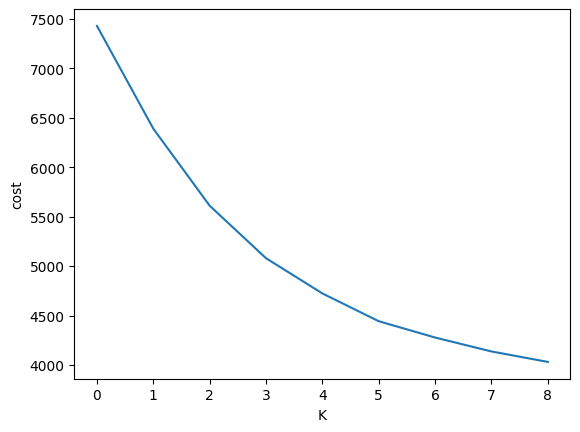

In [17]:
#Use elbow method to detect optimal number of K

cost = []
# Define the range of K
for cluster in range(1, 10):
    try:
        #Create a KPrototypes instance with the current number of clusters K
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Cao', random_state = 0)
        kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break
# Plotting the elbow curve
plt.plot(cost)
plt.xlabel('K')
plt.ylabel('cost')
plt.show

# cost (sum distance): confirm visual clue of elbow plot
# KneeLocator class will detect elbows if curve is convex; if concave, will detect knees
knee_point = KneeLocator(
        x=range(1,10),
        y=cost,
        S=0.1, curve="convex", direction="decreasing", online=True)

print("Elbow at k =", f'{knee_point.elbow:.0f} clusters')

The Elbow method is used to decide the optimal number of clusters (k). The method plots the values of the cost function produced by different values of k, where cost is a similarity measure that combines both categorical variables and numerical variables calculated between the cluster prototypes and the object. The cost generally decreases when k increases because more clusters result in smaller intra-cluster distances. The elbow point is where adding more clusters does not significantly improve the clustering quality.

From the figure below, we can select k=4 as the optimal number of clusters. This is identified as the 'elbow point', where the cost starts decreasing in a linear fashion beyond k = 4. The KneeLocator library is used to confirm the visual identification of the elbow point, ensuring the optimal value of k is obtained.

In [18]:
#Build the Kprototype model with 4 clusters
kprototype = KPrototypes(n_jobs = -1, n_clusters = 4, init = 'Cao', random_state = 42)
clusters = kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


## Analysis of K-Prototypes Clustering

In [19]:
# Convert bike_df_cluster back into the original dataset (before scaling)
bike_df_cluster = bike_df_fe.copy()
drop_col = ['Dew point temperature', 'Date']
bike_df_cluster = bike_df_cluster.drop(drop_col, axis=1)

# Add clusters to original dataset (before scaling)
bike_df_cluster['clusters'] = clusters.astype(np.int64)

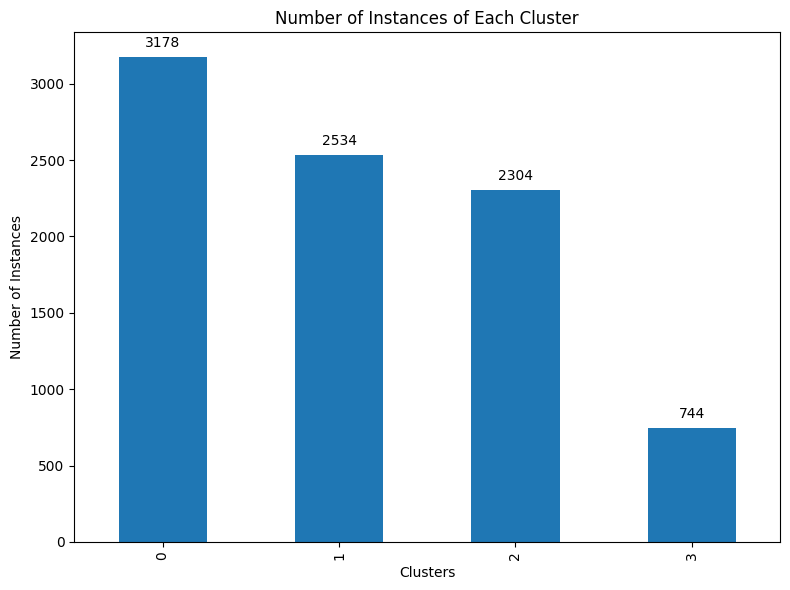

In [20]:
#Display the volume of each cluster

plt.figure(figsize=(8, 6))

ax = bike_df_cluster['clusters'].value_counts().plot(kind='bar')
plt.xlabel('Clusters')
plt.ylabel('Number of Instances')
plt.title('Number of Instances of Each Cluster')

for p in ax.patches:
    ax.annotate(str(p.get_height()),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                xytext=(0, 5),
                textcoords='offset points',
                fontsize=10)

plt.tight_layout()  # Ensure tight layout to prevent clipping of annotations
plt.show()
# The barplot shows the number occurrences in each cluster. Cluster 0 has the most observation (clost  to 4000)
#followed by cluster 2, with cluster 1 having the least occurrences

The bar chart above reveals the distribution of the clusters, showing the majority of the instances are in cluster 0 with 3178 instances, followed by cluster 2 with 2,534 instances, and cluster 3 with 2304 instances. Cluster 3 has the fewest instances, totaling 744.


<ipython-input-25-0d8ba78e0e8b>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='clusters', y='Temperature', data=bike_df_cluster, palette='viridis')
<ipython-input-25-0d8ba78e0e8b>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='clusters', y='Hour', data=bike_df_cluster, palette='viridis')


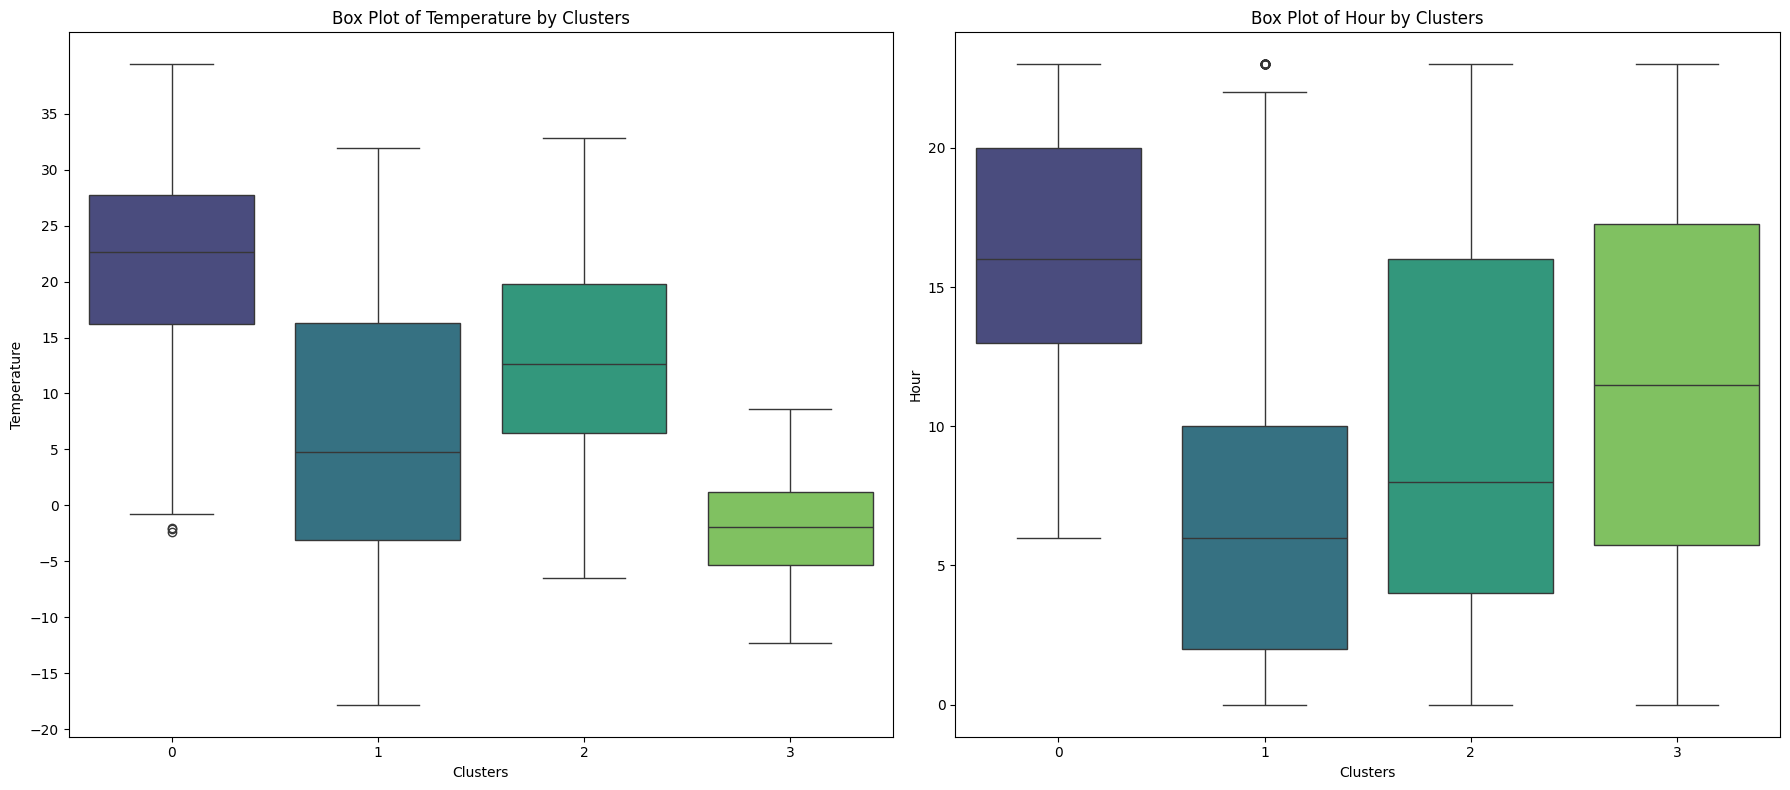

In [ ]:
# Create a figure with two subplots
plt.figure(figsize=(18, 8))

# Plotting the box plot of Temperature by Clusters
plt.subplot(1, 2, 1)
sns.boxplot(x='clusters', y='Temperature', data=bike_df_cluster, palette='viridis')
plt.title('Box Plot of Temperature by Clusters')
plt.xlabel('Clusters')
plt.ylabel('Temperature')
plt.yticks(np.arange(-20, 40, step=5))

# Plotting the second box plot of Hour by Clusters
plt.subplot(1, 2, 2)
sns.boxplot(x='clusters', y='Hour', data=bike_df_cluster, palette='viridis')
plt.title('Box Plot of Hour by Clusters')
plt.xlabel('Clusters')
plt.ylabel('Hour')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Summary of boxplot 1 (Temperature):

* Cluster 0: It has the highest median temperatures of around 23°C, an IQR from 15°C to 30°C. The range is from -3°C to 41°C. datapoints below -1°C are considered outliers in this cluster
* Cluster 1: It has a median temperature of around 4°C, an IQR from -3°C to 16°C. The range is the largest out of all clusters, from -18°C to 32°C
* Cluster 2: It has a median temperature of around 12°C, an IQR from 6°C to 19°C. The range is from -7°C to 33°C
* Cluster 3: It has the lowest median temperature of about -3°C, an IQR from -6°C to 1°C. The range is from -13°C to 8°C

Summary of boxplot 1 (Hour):
* Cluster 0: Occurrences mainly happen later in the day, with a largest median hour around 5 PM and an IQR from 1 PM to 8 PM. No instances occurred from 12am to 6am
* Cluster 1: Occurrences tend to happen in early morning. it has the lowest median of around 6 AM, with an IQR from 2 AM to 10 AM; instances at 11 PM are outliers
* Cluster 2: Occurrences tend to happen in morning, with a median hour around 8 AM and an IQR from 4 AM to 3 PM
* Cluster 3: Occurrences tend to happen around late morning, with a median hour around 11 AM and an IQR from 6 AM to 5 PM

In [21]:
# Extract the nuemerical columns from the dataset excluding 'Day', 'Year', and 'clusters' for mean calculation
numeric_cols_for_mean = bike_df_cluster.select_dtypes(include=[np.number]).drop(columns=['Day', 'Year', 'clusters'])

# Compute mean statistics by cluster
mean_stats_by_cluster = numeric_cols_for_mean.groupby(bike_df_cluster['clusters']).mean()

# Display the mean statistics
print(mean_stats_by_cluster)

          Rented Bike Count       Hour  Temperature   Humidity  Wind speed  \
clusters                                                                     
0               1256.708307  16.003776    21.489553  49.018565    2.072907   
1                349.914365   7.310576     6.262036  54.348461    1.558248   
2                480.243924   9.895399    13.076215  75.967014    1.424045   
3                249.099462  11.500000    -1.928763  55.825269    1.737769   

           Visibility  Solar Radiation  Rainfall  Snowfall  
clusters                                                    
0         1734.234110         1.180223  0.022215  0.000000  
1         1805.320442         0.196965  0.037727  0.072139  
2          655.089844         0.253411  0.478082  0.086285  
3         1332.243280         0.203884  0.046774  0.370968  


The average rented bike count in Cluster 0 (1256.7 per hour) is significantly more than that of the other three clusters. Cluster 2 follows with 480.2 per hour, then Cluster 1 with 349.9 per hour, and Cluster 3 with the lowest at 249.1 per hour. The average hour and temperature align with the boxplot results discussed earlier. Bike usage in Cluster 0 tends to occur later in the day and at the highest temperature, with the mean time around 4 pm and an average temperature of 21.49°C. Cluster 2 is the second warmest, with an average temperature of 13.08°C, and tends to have bike usage earlier in the day (around 10 am on average). Cluster 1 has the earliest mean time (approximately 7:30 am) and a mean temperature of 6.3°C. As for Cluster 3, it has a mean time of around 12 pm and the lowest mean temperature of -1.93°C.




Regarding other features, Cluster 0 has the highest average wind speed (2.07 m/s) and solar radiation (1.18 MJ/m²), the second highest visibility (1734.23 meters), as well as the lowest average rainfall (0.022 mm), snowfall (0 cm), and humidity level (49.02%). Cluster 1 has the highest visibility (1805.32 meters) and moderate levels of all other features. Cluster 2 has the highest humidity level (75.97%) and the lowest visibility (655.09 meters), the slowest mean wind speed (1.42 m/s), and the heaviest rainfall (0.478 mm). Cluster 3 has the heaviest snowfall (0.371 cm).




From all this information obtained from this table, it can be observed that nicer weather can lead to a higher demand for rental bikes. With the warmest and sunniest weather, high enough visibility, as well as the lowest rainfall and snowfall, Cluster 0, as a result, has a significantly higher demand for rental bikes. Of all weather factors, temperature is the most influential one. Cluster 2, compared to cluster 1, has a warmer mean temperature, but lower visibility, and heavier rainfall and snowfall. Despite these conditions, the mean number of rented bike count in cluster 2 is higher, indicating that temperature is more influential. This finding supports the Pearson correlation results we conducted.


In [22]:
# Group by clusters and aggregate using lambda function to find mode
cluster_result_cat = bike_df_cluster.groupby(['clusters']).agg(lambda x: pd.Series.mode(x).iat[0])[['Seasons', 'Holiday', 'Functioning Day', 'Month', 'Day of the week', 'Week status']]
print(cluster_result_cat)

         Seasons     Holiday Functioning Day Month Day of the week Week status
clusters                                                                      
0         Summer  No Holiday             Yes   Aug          Friday     Weekday
1         Winter  No Holiday             Yes   Jan          Sunday     Weekday
2         Spring  No Holiday             Yes   Mar          Monday     Weekday
3         Winter  No Holiday             Yes   Dec          Friday     Weekday


Because of the imbalance distribution of function day, week status, and holiday, the majority of instances in all three clusters occur on weekdays, functional days, and non-holidays. As for Seasons, month, and day of the week, it is discussed below

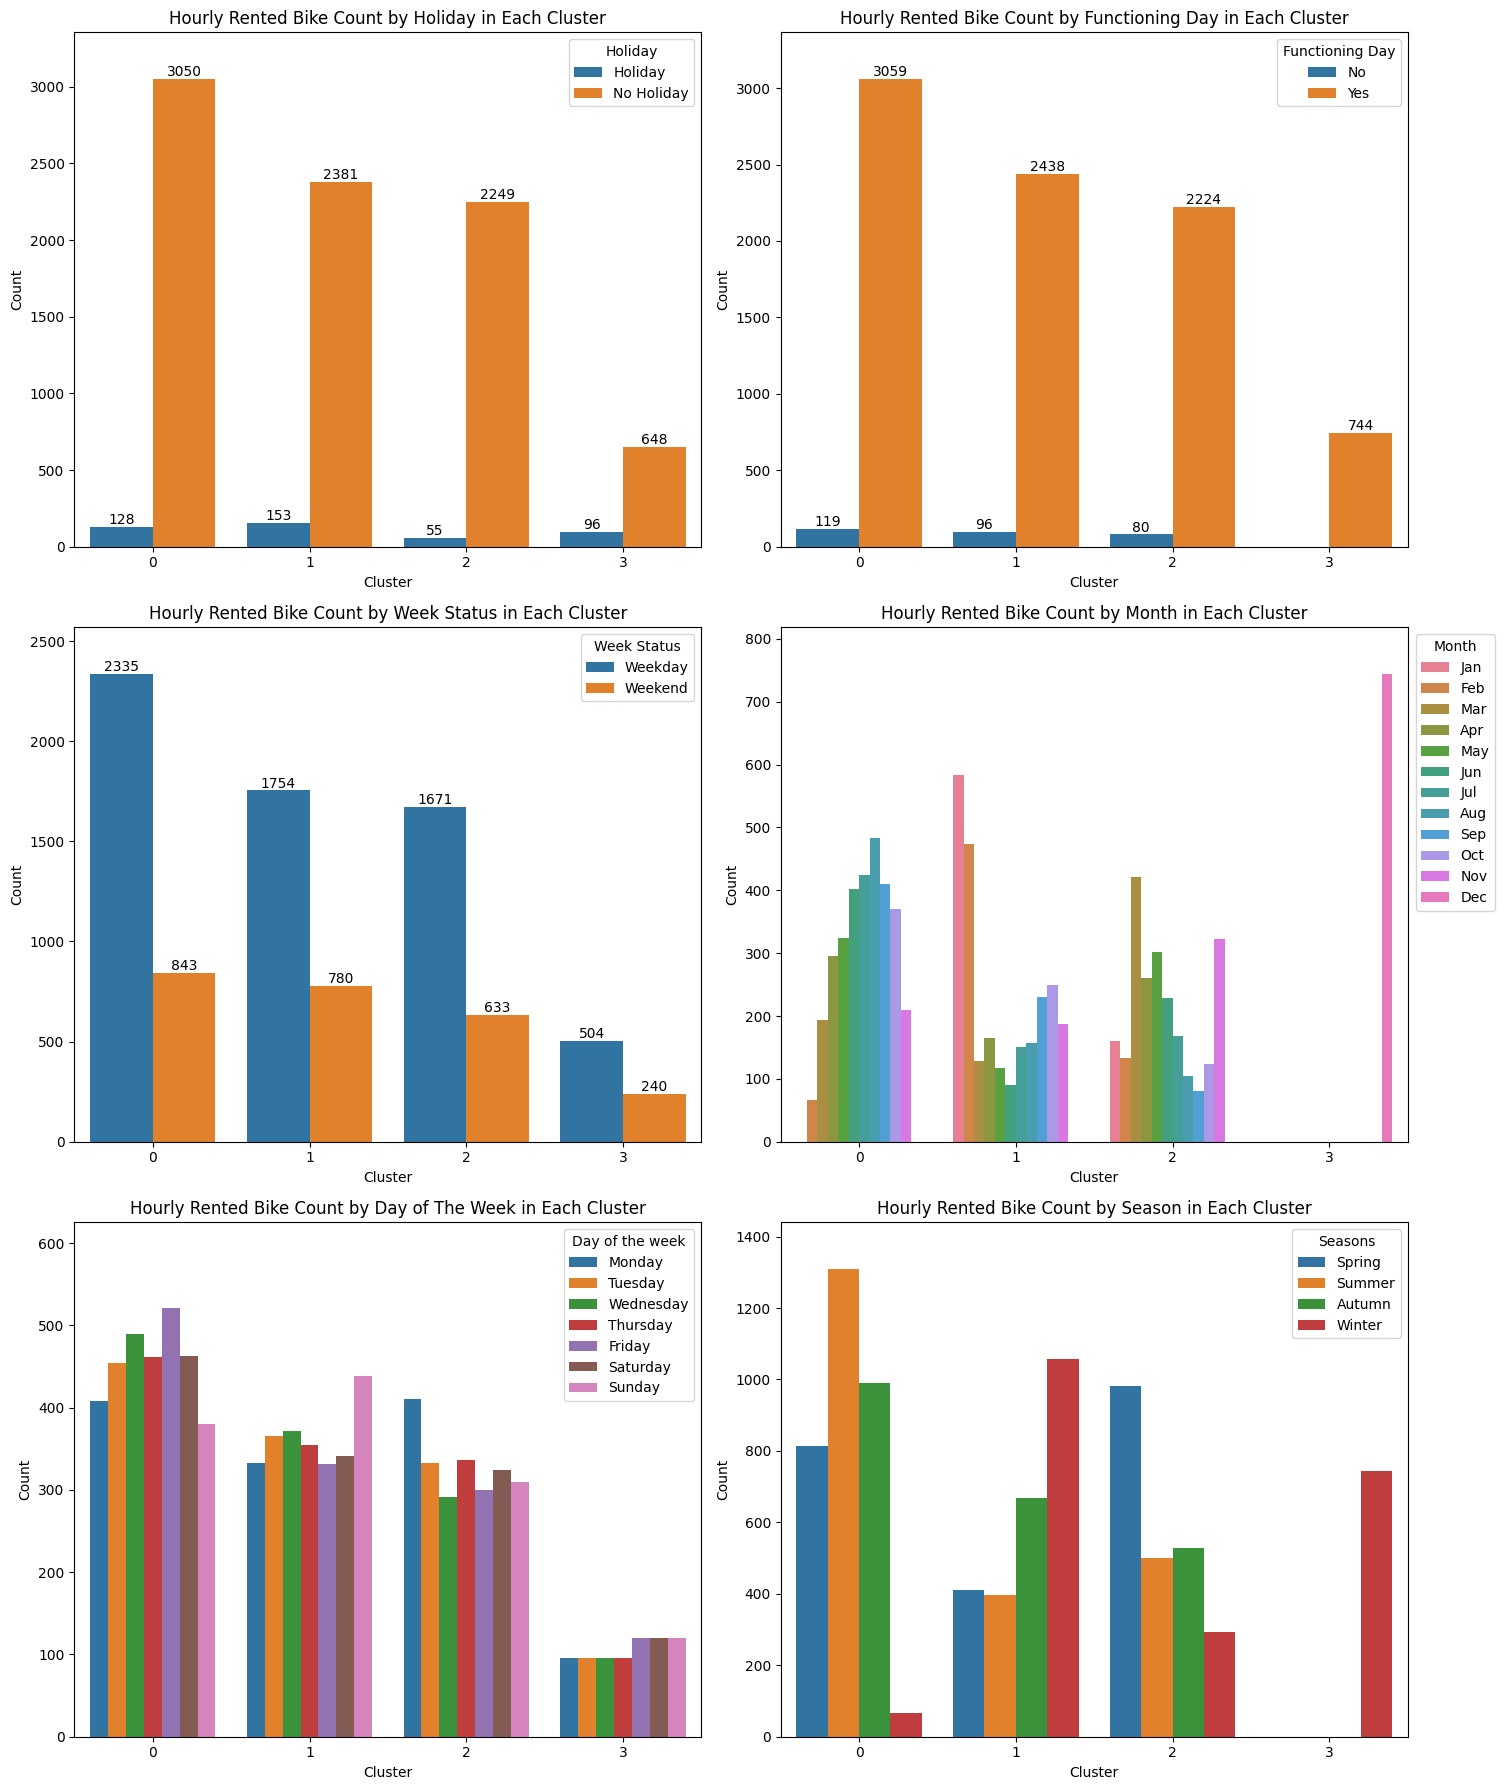

In [ ]:
# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# Plot 1: Holiday by Clusters
holiday_counts = bike_df_cluster.groupby(['clusters', 'Holiday']).size().reset_index(name='count')
sns.barplot(x='clusters', y='count', hue='Holiday', data=holiday_counts, ax=axes[0, 0])
axes[0, 0].set_title('Hourly Rented Bike Count by Holiday in Each Cluster')
axes[0, 0].set_xlabel('Cluster')
axes[0, 0].set_ylabel('Count')
axes[0, 0].legend(title='Holiday')
axes[0, 0].set_ylim(0, holiday_counts['count'].max() * 1.1)  # Adjust y-axis limit

# Add count values above bars
for p in axes[0, 0].patches:
    height = p.get_height()
    if height > 0:  # Only annotate if height > 0
        axes[0, 0].annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                            ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Plot 2: Functioning Day by Clusters
functioning_counts = bike_df_cluster.groupby(['clusters', 'Functioning Day']).size().reset_index(name='count')
sns.barplot(x='clusters', y='count', hue='Functioning Day', data=functioning_counts, ax=axes[0, 1])
axes[0, 1].set_title('Hourly Rented Bike Count by Functioning Day in Each Cluster')
axes[0, 1].set_xlabel('Cluster')
axes[0, 1].set_ylabel('Count')
axes[0, 1].legend(title='Functioning Day')
axes[0, 1].set_ylim(0, functioning_counts['count'].max() * 1.1)  # Adjust y-axis limit

# Add count values above bars
for p in axes[0, 1].patches:
    height = p.get_height()
    if height > 0:  # Only annotate if height > 0
        axes[0, 1].annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                            ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Plot 3: Week Status by Clusters
week_counts = bike_df_cluster.groupby(['clusters', 'Week status']).size().reset_index(name='count')
sns.barplot(x='clusters', y='count', hue='Week status', data=week_counts, ax=axes[1, 0])
axes[1, 0].set_title('Hourly Rented Bike Count by Week Status in Each Cluster')
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('Count')
axes[1, 0].legend(title='Week Status')
axes[1, 0].set_ylim(0, week_counts['count'].max() * 1.1)  # Adjust y-axis limit

# Add count values above bars
for p in axes[1, 0].patches:
    height = p.get_height()
    if height > 0:  # Only annotate if height > 0
        axes[1, 0].annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                            ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Plot 4: Month by Clusters
Month_counts = bike_df_cluster.groupby(['clusters', 'Month']).size().reset_index(name='count')
Month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
sns.barplot(x='clusters', y='count', hue='Month', data=Month_counts, hue_order=Month_order, ax=axes[1, 1])
axes[1, 1].set_title('Hourly Rented Bike Count by Month in Each Cluster')
axes[1, 1].set_xlabel('Cluster')
axes[1, 1].set_ylabel('Count')
axes[1, 1].legend(title='Month', loc='upper right', bbox_to_anchor=(1.15, 1))
axes[1, 1].set_ylim(0, Month_counts['count'].max() * 1.1)  # Adjust y-axis limit

# Plot 5: Day of the Week by Clusters
Day_of_the_week_counts = bike_df_cluster.groupby(['clusters', 'Day of the week']).size().reset_index(name='count')
Day_of_the_week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.barplot(x='clusters', y='count', hue='Day of the week', data=Day_of_the_week_counts, hue_order=Day_of_the_week_order, ax=axes[2, 0])
axes[2, 0].set_title('Hourly Rented Bike Count by Day of The Week in Each Cluster')
axes[2, 0].set_xlabel('Cluster')
axes[2, 0].set_ylabel('Count')
axes[2, 0].legend(title='Day of the week')
axes[2, 0].set_ylim(0, Day_of_the_week_counts['count'].max() * 1.2)  # Adjust y-axis limit

# Plot 6: Season by Clusters
season_counts = bike_df_cluster.groupby(['clusters', 'Seasons']).size().reset_index(name='count')
season_order = ['Spring', 'Summer', 'Autumn', 'Winter']
sns.barplot(x='clusters', y='count', hue='Seasons', data=season_counts, hue_order=season_order, ax=axes[2, 1])
axes[2, 1].set_title('Hourly Rented Bike Count by Season in Each Cluster')
axes[2, 1].set_xlabel('Cluster')
axes[2, 1].set_ylabel('Count')
axes[2, 1].legend(title='Seasons')
axes[2, 1].set_ylim(0, season_counts['count'].max() * 1.1)  # Adjust y-axis limit

plt.tight_layout()
plt.savefig('bike_rental_analysis.png', dpi=300)  # Save as PNG file with 300 dpi (adjust as needed)
plt.show()

The the graphs above, it can be found that, for week status and functional day, even though clusters with more instances have more occurrences of the minority classes (weekend and non-functional day, respectively), the proportions of these two minority classes across all clusters remain relatively unchanged, being around 3% and 30% respectively, except for the functional day in cluster 3, which has 0% non-functional day. As for holiday, it was found that the proportion of the minority class (holiday) in cluster 3 (6%) is a lot higher than that of the other clusters: more than 4.5 times that in Cluster 1, more than 2.5 times that in Cluster 2, and 1.5 times that in Cluster 0.

Regarding the distribution by day of the week, no significant differences are observed across the days of the week in each cluster. The main differences of the 4 clusters are in months and seasons. Even though most of the instances in cluster 1 and 3, if not all,  are in winter, they are still easily differentiated. In cluster 3, 100% of the instances are in early winter (December), whereas instances in cluster 1 primarily occur in mid to late winter (from January to February). For clusters 0 and 2, the majority of instances are in warmer seasons. Cluster 0 has the highest number of cases in summer (June to August), while cluster 2 has the majority of cases in spring (from March to May). The peak months for clusters 0, 1, 2, and 3 are August, January, March, and December, respectively.

## Application of Four Regression Models (Before Feature Engineering)

The 'Dew point temperature' column will be dropped as there is a significant correlation between temperature and dew point temperature, and temperature has a higher correlation with the target variable (rented bike count).

In [ ]:
# Make a copy of bike_df for regression models
Bike_df_regression = bike_df.copy

# Drop 'Dew point temperature' column from the dataset
Bike_df_regression = bike_df.drop('Dew point temperature', axis=1)
# Use one-hot encoding on categorical columns
Bike_df_encoded_data = pd.get_dummies(Bike_df_regression, columns = ['Date', 'Seasons', 'Holiday', 'Functioning Day'], dtype=float)

In [ ]:
# Define a random seed for reproducibility
random_seed = 42

#Define the independent variables (X) and depentent (target) varibale (y)
X = Bike_df_encoded_data.loc[:, Bike_df_encoded_data.columns!='Rented Bike Count']
y = Bike_df_encoded_data['Rented Bike Count']
#Split the dataste into a 75% training set and a 25% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state= random_seed)

In the next 4 subsections we consider 4 regression models. For each model we perform a grid search with cross-validation to find their best set of hyperparameters. Grid search takes in a list of hyperparameters along with a few candidate values per hyperparameter. It considers all possible combinations of these values and finds the combination that results in the highest R-squared.

### 1. Gradient Boosting Machine

Gradient Boosting Machine is an ensemble method that utilizes multiple learners to create a powerful model. Gradient boosting involves creating an ensemble of weak decision trees and improving upon them iteratively. The learning process in GBM involves
fitting each weak learner to the gradient of the loss function based on the previous ensemble's
predictions. At every iteration in GBM a new weak learner is trained to
correct the errors made by the previous ensemble.


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
# Initialize the Gradient Boosting Regressor model
GBM_model = GradientBoostingRegressor(random_state=random_seed)

# Train the GBM on the training set
GBM_model.fit(X_train, y_train)

# Predict on the test set
GBM_y_pred = GBM_model.predict(X_test)

# Evaluate the model on test set uning R2, MSE, and MAE
GBM_r2 = r2_score(y_test, GBM_y_pred)
GBM_mse = mean_squared_error(y_test, GBM_y_pred)
GBM_mae = mean_absolute_error(y_test, GBM_y_pred)

# Display the result of the r2 socre
print(f"R-squared score of GBM (before tuning) on test set: {GBM_r2:.4f}")
print(f"Mean Squared Error (MSE) of GBM on test set: {GBM_mse:.4f}")
print(f"Mean Absolute Error (MAE) of GBM on test set: {GBM_mae:.4f}")


R-squared score of GBM (before tuning) on test set: 0.8198
Mean Squared Error (MSE) of GBM on test set: 73731.1542
Mean Absolute Error (MAE) of GBM on test set: 177.5795


A grid search of specified hyperparameters was conducted locally to determine the most optimal combination.. Due to the limitation of Google Colab (max. 12 hours run time) and the complexity of the computation, code below was run locally. the outcome of the codes below was {'max_depth': 9, 'n_estimators': 500}. This is one of our baseline models.

In [ ]:
# Use grid search to find the best hyperparamters for GMB

# Initialize GBM
model = GradientBoostingRegressor(random_state=random_seed)

# Define the hyperparameter grid to search over
param_grid = {
    'n_estimators': list(range(20, 520, 20)),  # n_estimators from 20 to 500
    'max_depth': list(range(1, 17, 2))       # max_depth from 1 to 15
}

# Define the Repeated K-Folds cross-validator with 10 splits and 3 repeats
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=random_seed)

# Initialize GridSearchCV on validation sets for hyperparameter tuning with R-squared as the scoring metric
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, verbose=2, scoring='r2')

# Execute the grid search on the training data
grid_result = grid_search.fit(X_train, y_train)

# Display the best hyperparameters found during grid search
print("Best hyperparameters of GBM:", grid_result.best_params_)

# Best hyperparameters of GBM: 'max_depth': 9, 'n_estimators': 500

After fine-tuning, the best model ({Max_depth: 9, n_estimators: 500}) is identified and trained on the training set. Later this model is evaluated on the test set and its performance is summarized in the block below.

In [ ]:
# Initialize GBM with tuned hyperparameters
GBM_tuned = GradientBoostingRegressor(n_estimators=500, max_depth=9, random_state=random_seed)

# Train the tuned GBM on the training set
start_time = time.time()
GBM_tuned.fit(X_train, y_train)
end_time = time.time()
GBM_training_time = end_time - start_time

# Predict on the test set
GBM_tuned_pred = GBM_tuned.predict(X_test)

# Evaluate the model on test set uning R2, MSE, and MAE
GBM_tuned_r2 = r2_score(y_test, GBM_tuned_pred)
GBM_tuned_mse = mean_squared_error(y_test, GBM_tuned_pred)
GBM_tuned_mae = mean_absolute_error(y_test, GBM_tuned_pred)


# Display the result of the r2 socre
print(f"R-squared score of tuned GBM on test set: {GBM_tuned_r2:.4f}")
print(f"Mean Squared Error (MSE) of tuned GBM on test set: {GBM_tuned_mse:.4f}")
print(f"Mean Absolute Error (MAE) of tuned GBM on test set: {GBM_tuned_mae:.4f}")
print(f"Training time of GBM: {GBM_training_time} seconds")

R-squared score of tuned GBM on test set: 0.8998
Mean Squared Error (MSE) of tuned GBM on test set: 41001.2332
Mean Absolute Error (MAE) of tuned GBM on test set: 115.4504
Training time of GBM: 56.18000674247742 seconds


### 2. CUBIST

CUBIST combins decision trees
and linear regressions to form a powerful methods. At each node of the tree there is a linear model that contributes to the final prediction of the model. The prediction of this model can be further improved by utilizing boosting with multiple
training committees, and instance-based learning. Having a training committess resembles the boosting method where a series of trees are created to improve the model. Instance-based learning refines the predictions based on the values close to the training instances, similar to K-nearest neighbors.

Here we evaluate the performance of CUBIST before tuning.

In [ ]:
# below are the performance of CIBUST (before tuning)

# Initialize the CUBIST model
CUBIST_model = Cubist(random_state=random_seed)

# Train the CUBIST on the training set
CUBIST_model.fit(X_train, y_train)

# Predict on the test set
CUBIST_y_pred = CUBIST_model.predict(X_test)

# Evaluate the model on test set uning R2, MSE, and MAE
CUBIST_r2 = r2_score(y_test, CUBIST_y_pred)
CUBIST_mse = mean_squared_error(y_test, CUBIST_y_pred)
CUBIST_mae = mean_absolute_error(y_test, CUBIST_y_pred)

# Display the result of the r2 socre
print(f"R-squared score of CUBIST (before tuning) on test set: {CUBIST_r2:.4f}")
print(f"Mean Squared Error (MSE) of CUBIST (before tuning) on test set: {CUBIST_mse:.4f}")
print(f"Mean Absolute Error (MAE) of CUBIST (before tuning) on test set: {CUBIST_mae:.4f}")


R-squared score of CUBIST (before tuning) on test set: 0.8406
Mean Squared Error (MSE) of CUBIST (before tuning) on test set: 65240.1888
Mean Absolute Error (MAE) of CUBIST (before tuning) on test set: 151.0555


Same for Cubist, due to the complexity of the computation, the code for grid search was run locally. it was found that the best combination of CIBUST is 'n_committees': 50, 'neighbors': 3. This is one of our baseline models.

In [ ]:
# Use grid search on the training set to the best hyperparameters for CUBIST

# hyperparameter grid to search over
n_committees_list = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
neighbors_list = [1, 3, 5, 7]

# Define the Repeated K-Folds cross-validator with 10 splits and 3 repeats
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=random_seed)

# Initialize variables to store the best parameters and the best score
best_score = -np.inf
best_params = {}

# Grid search
for n_committees in n_committees_list:
    for neighbors in neighbors_list:
        model = Cubist(n_committees=n_committees, neighbors=neighbors)

        # Initialize a list to store cross-validated scores
        cv_scores = []

        # Perform cross-validation
        for train_ix, val_ix in cv.split(X_train):
            X_train_cv, X_val_cv = X_train.iloc[train_ix], X_train.iloc[val_ix]
            y_train_cv, y_val_cv = y_train.iloc[train_ix], y_train.iloc[val_ix]

            # Fit the model on the training data
            model.fit(X_train_cv, y_train_cv)

            # Predict on the validation data
            y_pred_cv = model.predict(X_val_cv)

            # Calculate the R2 score for this fold
            score = r2_score(y_val_cv, y_pred_cv)

            # Store the score
            cv_scores.append(score)

        # Calculate the mean cross-validated score
        mean_cv_score = np.mean(cv_scores)

        # Update the best score and parameters if the model in this fold is better
        if mean_cv_score > best_score:
            best_score = mean_cv_score
            best_params = {'n_committees': n_committees, 'neighbors': neighbors}

# Display the best hyperparameters found during grid search
print("Best hyperparameters of CUBIST:", best_params)

# Best hyperparameters of CUBIST: 'n_committees': 50, 'neighbors': 3

After fine-tuning, the best model is identified and trained on the training set. Later this model is evaluated on the test set and its performance is summarized in the block below.

In [ ]:
# Initialize CUBIST with tuned hyperparameters
CUBIST_tuned = Cubist(n_committees=50, neighbors=3, random_state=random_seed)

# Train the tuned CUBIST on the training set
start_time = time.time()
CUBIST_tuned.fit(X_train, y_train)
end_time = time.time()
CUBIST_training_time = end_time - start_time

# Predict on the test set
CUBIST_tuned_y_pred = CUBIST_tuned.predict(X_test)

# Evaluate the model on test set uning R2, MSE, and MAE
CUBIST_tuned_r2 = r2_score(y_test, CUBIST_tuned_y_pred)
CUBIST_tuned_mse = mean_squared_error(y_test, CUBIST_tuned_y_pred)
CUBIST_tuned_mae = mean_absolute_error(y_test, CUBIST_tuned_y_pred)

# Display the result of the r2 socre
print(f"R-squared score of tuned CUBIST on test set: {CUBIST_tuned_r2:.4f}")
print(f"Mean Squared Error (MSE) of tuned CUBIST on test set: {CUBIST_tuned_mse:.4f}")
print(f"Mean Absolute Error (MAE) of tuned CUBIST on test set: {CUBIST_tuned_mae:.4f}")
print(f"Training time of CUBIST: {CUBIST_training_time} seconds")



R-squared score of tuned CUBIST on test set: 0.9201
Mean Squared Error (MSE) of tuned CUBIST on test set: 32680.6712
Mean Absolute Error (MAE) of tuned CUBIST on test set: 104.1602
Training time of CUBIST: 83.70118856430054 seconds


### 3. Multi Layer Perceptron (MLP)

Multi Layer Perceptron is a dense neural network with
multiple dense layers which uses the MSE loss function, Adam as the optimiser and ReLU as the
activation function. All the dense layers have numerous
trainable parameters and apply the weighted sum to transforme the input data. After applying
the transformation defined by each layer and the activations to the input data, it calculates the
13
MSE loss function which is the error output of the model. Then the steepest increase in the loss
function (i.e. gradient) is calculated and the parameters are adjusted in the opposite direction of
the gradient. The process of passing an input to the model, calculating the loss and updating the
trainable parameters by gradient descent is repeated several times to update the parameters of the
model and reduce the loss function.

Here our model has 4 layers with different sizes.

In [ ]:
# Convert dataframe to numpy
X_train_np, X_test_np, y_train_np, y_test_np = X_train.values, X_test.values, y_train.values, y_test.values

# Separate numerical and categorical features
numerical_indices = list(range(9))
categorical_indices = list(range(9, X_train_np.shape[1]))
X_train_numerical = X_train_np[:, numerical_indices]
X_train_categorical = X_train_np[:, categorical_indices]

# Model defenition
def create_mlp_model():
    model = Sequential([
        Dense(200, input_dim=X_train_s.shape[1], activation='relu'),
        Dense(100, activation='relu'),
        Dense(50, activation='relu'),
        Dense(1, activation='relu')
    ])

    return model

Method 1: scaling data using Standardization

Similar to the previous models, due to the complexity of the computation, the code for grid search was run locally. For this version of the model the input data is standardized to make sure the values have a zero mean with a unit standard deviation. This preprocessing method significantly improved the results.

After fine-tuning, the best model is identified and trained on the training set. Later this model is evaluated on the test set and its performance is summarized in the following blocks.

In [ ]:
# Standardize the data
scaler = StandardScaler()
X_train_numerical_scaled = scaler.fit_transform(X_train_numerical)
X_test_numerical_scaled = scaler.transform(X_test_np[:, numerical_indices])
X_train_s = np.hstack((X_train_numerical_scaled, X_train_categorical))
X_test_s = np.hstack((X_test_numerical_scaled, X_test_np[:, categorical_indices]))

# scikit-learn API wrapper for Keras.
MLP_model = KerasRegressor(build_fn=create_mlp_model, verbose=0, loss="mse", optimizer="Adam")

# Cross validation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

# Grid search
param_grid = {
    'batch_size': list(range(2, 128, 10)),
    'epochs': list(range(50, 300, 50)),
    'optimizer__learning_rate': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1],
}
grid = GridSearchCV(estimator= MLP_model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='r2', verbose=4)
grid_result = grid.fit(X_train_s, y_train)

# Display the best hyperparameters found during grid search
print("Best hyperparameters of MLP:", best_params)

# Best hyperparameters of MLP: 'batch size': 2, 'epochs': 250, 'learning rate': 0.001


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

# MLP with tuned huperparameters
MLP_model = create_mlp_model()
optimizer = Adam(learning_rate = 0.001)
MLP_model.compile(optimizer=optimizer, loss='mse')

# Train the tuned MLP on the training set
start_time = time.time()
MLP_model.fit(X_train_s, y_train, epochs=250, validation_split=0., batch_size=2, verbose=0)
end_time = time.time()
MLP_training_time = end_time - start_time

# Predict on the test set
MLP_tuned_y_pred = MLP_model.predict(X_test_s)

# Evaluate the model on test set (R-squared score, MSE)
MLP_tuned_r2 = r2_score(y_test, MLP_tuned_y_pred)
MLP_tuned_mse = mean_squared_error(y_test, MLP_tuned_y_pred)
MLP_tuned_mae = mean_absolute_error(y_test, MLP_tuned_y_pred)

# Display the result of the r2 socre
print("R-squared of tuned MLP on Test Set:", f"{MLP_tuned_r2:.4f}")
print(f"Mean Squared Error (MSE) of tuned MLP on test set: {MLP_tuned_mse:.4f}")
print(f"Mean Absolute Error (MAE) of tuned MLP on test set: {MLP_tuned_mae:.4f}")
print(f"Training time of MLP: {MLP_training_time} seconds")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R-squared of tuned MLP on Test Set: 0.9300
Mean Squared Error (MSE) of tuned MLP on test set: 28645.7074
Mean Absolute Error (MAE) of tuned MLP on test set: 99.2962
Training time of MLP: 2091.8571858406067 seconds


Method 2: scaling data using Normalization

Similar to the previous models, due to the complexity of the computation, the code for grid search was run locally. For this version of the model the input data is normalized to make sure the values of each feature are scaled and translated to range 0 to 1. This preprocessing method significantly improved the results. However, normalization is not as effective for MLP as standardization because it is sensitive to outliers and affects the performance of our MLP model negatively.

After fine-tuning, the best model ({'batch_size': 42, 'epochs': 200, 'optimizer__learning_rate': 0.005}) is identified and trained on the training set. Later this model is evaluated on the test set and its performance is summarized in the following blocks.

In [ ]:
# Normalization the data
scaler = MinMaxScaler()
X_train_numerical_scaled = scaler.fit_transform(X_train_numerical)
X_test_numerical_scaled = scaler.transform(X_test_np[:, numerical_indices])
X_train_s = np.hstack((X_train_numerical_scaled, X_train_categorical))
X_test_s = np.hstack((X_test_numerical_scaled, X_test_np[:, categorical_indices]))

# scikit-learn API wrapper for Keras.
MLP_model = KerasRegressor(build_fn=create_mlp_model, verbose=0, loss="mse", optimizer="Adam")

# Cross validation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

# Grid search
param_grid = {
    'batch_size': list(range(2, 128, 10)),
    'epochs': list(range(50, 300, 50)),
    'optimizer__learning_rate': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1],
}
grid = GridSearchCV(estimator= MLP_model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='r2', verbose=4)
grid_result = grid.fit(X_train_s, y_train)

# Display the best hyperparameters found during grid search
print("Best hyperparameters of MLP:", best_params)

# Best hyperparameters of MLP: 'batch size': 42, 'epochs': 200, 'learning rate': 0.005

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

# MLP with tuned huperparameters
MLP_model = create_mlp_model()
optimizer = Adam(learning_rate = 0.005)
MLP_model.compile(optimizer=optimizer, loss='mse')

# Train the tuned MLP on the training set
start_time = time.time()
MLP_model.fit(X_train_s, y_train, epochs=200, validation_split=0., batch_size=42, verbose=0)
end_time = time.time()
MLP_training_time = end_time - start_time

# Predict on the test set
MLP_tuned_y_pred = MLP_model.predict(X_test_s)

# Evaluate the model on test set (R-squared score, MSE)
MLP_tuned_r2 = r2_score(y_test, MLP_tuned_y_pred)
MLP_tuned_mse = mean_squared_error(y_test, MLP_tuned_y_pred)
MLP_tuned_mae = mean_absolute_error(y_test, MLP_tuned_y_pred)

# Display the result of the r2 socre
print("R-squared of tuned MLP on Test Set:", f"{MLP_tuned_r2:.4f}")
print(f"Mean Squared Error (MSE) of tuned MLP on test set: {MLP_tuned_mse:.4f}")
print(f"Mean Absolute Error (MAE) of tuned MLP on test set: {MLP_tuned_mae:.4f}")
print(f"Training time of MLP: {MLP_training_time} seconds")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R-squared of tuned MLP on Test Set: 0.8600
Mean Squared Error (MSE) of tuned MLP on test set: 57285.6964
Mean Absolute Error (MAE) of tuned MLP on test set: 140.6469
Training time of MLP: 139.63201594352722 seconds


### 4. Ridge Regression Model

Ridge regression is a regularization approach to linear
regression that helps prevent overfitting, and enhances the model’s generalization performance.  Ridge regression reduces the coefficient estimates from their least-squares
values, resulting in the decrease in flexibility as the model is constrained from fitting the training
data as closely as possible.

Similar as MLP, two scaling methods were used for ridge regression model

Method 1: Scaling Data Using Standardization

The grid search suggest alpha value of 1.0 is the optimal value for this hyperparameter under this setting. The performance of this model is summarized on the following blocks.

In [ ]:
# Make a copy of bike_df for scaling
Bike_df_ridge_scale = bike_df.copy()
# Drop Dew point temperature
Bike_df_ridge_scale = Bike_df_ridge_scale.drop('Dew point temperature', axis=1)

# Use one-hot encoding on categorical columns
Bike_ridge_scale_encoded_data = pd.get_dummies(Bike_df_ridge_scale, columns = ['Date', 'Seasons', 'Holiday', 'Functioning Day'], dtype=float)

# Define a random seed for reproducibility
random_seed = 42

# Define the independent variables (X) and depentent (target) varibale (y)
X_scale = Bike_ridge_scale_encoded_data.loc[:, Bike_ridge_scale_encoded_data.columns!='Rented Bike Count']
y_scale = Bike_ridge_scale_encoded_data['Rented Bike Count']

#standardize the independent variables (scaling)
scaler = preprocessing.StandardScaler()
X_scale = scaler.fit_transform(X_scale)

# Split the dataste into a 75% training set and a 25% test set
X_train_scale, X_test_scale, y_train_scale, y_test_scale = train_test_split(X_scale, y_scale, test_size= 0.25, random_state= random_seed)

In [ ]:
# Use grid search on the training set to the best hyperparameters

# Initialize the Ridge Regression model
model = Ridge(random_state=random_seed)

# Define the parameter grid to search over
grid = dict()
grid['alpha'] = np.logspace(-4, 5, 10)  # Logarithmically spaced alpha values for Ridge

# Define the Repeated K-Folds cross-validator with 10 splits and 3 repeats
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=random_seed)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, verbose=2, scoring='r2')

# Execute the grid search on the training data
grid_result = grid_search.fit(X_train_scale, y_train_scale)

# Summarize the best score and configuration
print("Best hyperparameters of ridge regression:", grid_result.best_params_)

Fitting 30 folds for each of 10 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best hyperparameters of ridge regression: {'alpha': 1.0}


In [ ]:
# Initialize Ridge Regression model with the best hyperparameter (alpha=1), which is the default hyperparamter
ridge_reg = Ridge(alpha=1.0, random_state=random_seed)

# Train the model on the training set
start_time = time.time()
ridge_reg.fit(X_train_scale, y_train_scale)
end_time = time.time()
ridge_training_time = end_time - start_time

# Predict on the test set
ridge_reg_y_pred = ridge_reg.predict(X_test_scale)

# Evaluate the model on test set uning R2 score
ridge_reg_r2 = r2_score(y_test_scale, ridge_reg_y_pred)
ridge_reg_mse = mean_squared_error(y_test_scale, ridge_reg_y_pred)
ridge_reg_mae = mean_absolute_error(y_test_scale, ridge_reg_y_pred)

print("R-squared of ridge regression model (after scaling) on Test Set:", ridge_reg_r2)
print(f"Mean Squared Error (MSE) of ridge regression model (after scaling) on test set: {ridge_reg_mse:.4f}")
print(f"Mean Absolute Error (MAE) of ridge regression model (after scaling) on test set: {ridge_reg_mae:.4f}")
print(f"Training time of ridge regression (after scaling): {ridge_training_time} seconds")


R-squared of ridge regression model (after scaling) on Test Set: 0.6236251554574981
Mean Squared Error (MSE) of ridge regression model (after scaling) on test set: 154012.9564
Mean Absolute Error (MAE) of ridge regression model (after scaling) on test set: 297.6028
Training time of ridge regression (after scaling): 0.15632939338684082 seconds


Method 2: Scaling Data Using Normalizating

The grid search suggest alpha value of 0.1 is the optimal value for this hyperparameter under this setting. The performance of this model is summarized on the following blocks.

In [ ]:
# Make a copy of bike_df for scaling
Bike_df_ridge_scale = bike_df.copy()
# Drop Dew point temperature
Bike_df_ridge_scale = Bike_df_ridge_scale.drop('Dew point temperature', axis=1)

# Use one-hot encoding on categorical columns
Bike_ridge_scale_encoded_data = pd.get_dummies(Bike_df_ridge_scale, columns = ['Date', 'Seasons', 'Holiday', 'Functioning Day'], dtype=float)

# Define a random seed for reproducibility
random_seed = 42

# Define the independent variables (X) and depentent (target) varibale (y)
X_scale = Bike_ridge_scale_encoded_data.loc[:, Bike_ridge_scale_encoded_data.columns!='Rented Bike Count']
y_scale = Bike_ridge_scale_encoded_data['Rented Bike Count']

# Normilization of the independent variables (scaling)
scaler = preprocessing.MinMaxScaler()
X_scale = scaler.fit_transform(X_scale)

# Split the dataste into a 75% training set and a 25% test set
X_train_scale, X_test_scale, y_train_scale, y_test_scale = train_test_split(X_scale, y_scale, test_size= 0.25, random_state= random_seed)


In [ ]:
# Use grid search on the training set to the best hyperparameters

# Initialize the Ridge Regression model
model = Ridge(random_state=random_seed)

# Define the parameter grid to search over
grid = dict()
grid['alpha'] = np.logspace(-4, 5, 10)  # Logarithmically spaced alpha values for Ridge

# Define the Repeated K-Folds cross-validator with 10 splits and 3 repeats
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=random_seed)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, verbose=2, scoring='r2')

# Execute the grid search on the training data
grid_result = grid_search.fit(X_train_scale, y_train_scale)

# Summarize the best score and configuration
print("Best hyperparameters of ridge regression:", grid_result.best_params_)

Fitting 30 folds for each of 10 candidates, totalling 300 fits
Best hyperparameters of ridge regression: {'alpha': 0.1}


In [ ]:
# Initialize Ridge Regression model with the best hyperparameter (alpha=.1), which is the default hyperparamter
ridge_reg = Ridge(alpha=0.1, random_state=random_seed)

# Train the model on the training set
start_time = time.time()
ridge_reg.fit(X_train_scale, y_train_scale)
end_time = time.time()
ridge_training_time = end_time - start_time

# Predict on the test set
ridge_reg_y_pred = ridge_reg.predict(X_test_scale)

# Evaluate the model on test set uning R2 score
ridge_reg_r2 = r2_score(y_test_scale, ridge_reg_y_pred)
ridge_reg_mse = mean_squared_error(y_test_scale, ridge_reg_y_pred)
ridge_reg_mae = mean_absolute_error(y_test_scale, ridge_reg_y_pred)

print("R-squared of ridge regression model (after scaling) on Test Set:", ridge_reg_r2)
print(f"Mean Squared Error (MSE) of ridge regression model (after scaling) on test set: {ridge_reg_mse:.4f}")
print(f"Mean Absolute Error (MAE) of ridge regression model (after scaling) on test set: {ridge_reg_mae:.4f}")
print(f"Training time of ridge regression (after scaling): {ridge_training_time} seconds")


R-squared of ridge regression model (after scaling) on Test Set: 0.624263168556709
Mean Squared Error (MSE) of ridge regression model (after scaling) on test set: 153751.8808
Mean Absolute Error (MAE) of ridge regression model (after scaling) on test set: 297.3293
Training time of ridge regression (after scaling): 0.07404446601867676 seconds


## Summary of the Performance of the Four Regression Models

Out of the four models, MLP with standardization has the strongest performance with the highest R2 and the lowest MSE and MAE:

*   MLP (standardization): R2 of 94.5%, MSE of 22390.3, and MAE of 87.4
*   MLP (normalization): R2 of 86%, MSE of 57285.7, and MAE of 140.6
*   CUBIST: R2 of 92%, MSE of 32680.7, and MAE of 104.2
*   GBM: R2 of 90%, MSE of 41001.2, and MAE of 115.25
*   Ridge Regression (standardization): R2 of 62%, MSE of 154013.0, and MAE of 297.6
*   Ridge Regression (normalization): R2 of 62%, MSE of 153751.9, and MAE of 297.3

